<a href="https://colab.research.google.com/github/lennardwalter/multisensor/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git lfs install
!git clone https://github.com/lennardwalter/multisensor.git

Git LFS initialized.
fatal: destination path 'multisensor' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install dependencies (run once)
%pip install -q pytorch-forecasting "lightning>=2.0.0" optuna pyarrow fastparquet pandas matplotlib

In [4]:
import json
import math
from pathlib import Path
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import (
    Baseline,
    TemporalFusionTransformer,
    TimeSeriesDataSet,
)
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

pl.seed_everything(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)



INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Using device: cuda


In [5]:
# Configuration
PARQUET_PATH = "multisensor/exports_all_time/multisensor.parquet"
META_PATH = "multisensor/exports_all_time/multisensor.parquet.meta.json"

# 2. Find, filter (for numeric suffix), and sort the fragment paths
fragments = sorted([f for f in glob.glob(f"{PARQUET_PATH}.*") if f.split('.')[-1].isdigit()], key=lambda f: int(f.split('.')[-1]))

# 3. If fragments exist, concatenate them into the target file (the optional merge step)
if fragments:
    with open(PARQUET_PATH, 'wb') as out:
        [out.write(open(frag, 'rb').read()) for frag in fragments]
    print(f"Merge successful: {len(fragments)} files combined into {PARQUET_PATH}.")



Merge successful: 2 files combined into multisensor/exports_all_time/multisensor.parquet.


In [12]:
# Configuration part 2

# device selection; set to None to include all devices present
SELECTED_DEVICES = None

# time range filter: only use last N days of data; set to None to use all data
LAST_N_DAYS = 100  # e.g., 100 for last 100 days, None for all data

# metrics selection
# if empty/None, all metrics from meta will be used
# Available metrics:
#   continuous: co2, detection_distance, gas_resistance, humidity, light,
#               microphone_noise_level, pressure, temperature, uv_index, voc_equivalent
#   boolean:    moving_target, still_target (0.0/1.0 values)
METRICS_TO_USE = [
    "co2",
    "gas_resistance",
    "light",
    "voc_equivalent",
    "temperature",
    "humidity",
    "pressure",
    # "detection_distance",
    "microphone_noise_level",
    "uv_index",
    # "moving_target",
    # "still_target",
]
TARGET_METRIC = "co2"

# boolean metrics (will use ffill instead of interpolation, can be treated as categorical)
# these metrics only have values 0.0 and 1.0
BOOLEAN_METRICS = ["moving_target", "still_target"]
# whether to treat boolean metrics as categorical in the model (vs continuous)
BOOLEAN_AS_CATEGORICAL = True

# resampling and fill
RESAMPLE_FREQ = "1min"
FILL_METHOD = "interpolate"  # one of: interpolate|ffill|bfill|none
FILL_LIMIT = 30

# inactivity filtering (row-level sparsity before fill)
MIN_ACTIVE_RATIO_DEFAULT = 0.08
MIN_ACTIVE_RATIO_BY_METRIC = {
    "co2": 0.8,
    "gas_resistance": 0.8,
    "light": 0.4,
    "voc_equivalent": 0.2,
    "temperature": 0.03,}

# sequence lengths
MAX_ENCODER_LENGTH = 30
MAX_PREDICTION_LENGTH = 12

# training
BATCH_SIZE = 64
NUM_WORKERS = 0



In [13]:
# Data loading and preprocessing
import gc
import pyarrow.parquet as pq

def _apply_fill(
    df: pd.DataFrame,
    method: str,
    limit: int | None,
    boolean_cols: list[str] | None = None,
) -> pd.DataFrame:
    """Apply fill method to dataframe, with special handling for boolean columns.

    Boolean columns always use ffill (no interpolation) to preserve 0/1 values.
    """
    boolean_cols = boolean_cols or []
    bool_in_df = [c for c in boolean_cols if c in df.columns]
    continuous_cols = [c for c in df.columns if c not in bool_in_df]

    # handle boolean columns: always ffill (no interpolation)
    if bool_in_df:
        df[bool_in_df] = df[bool_in_df].ffill(limit=limit).bfill(limit=limit)

    # handle continuous columns based on method
    if continuous_cols:
        if method == "none":
            df[continuous_cols] = df[continuous_cols].ffill(limit=limit).bfill(limit=limit)
        elif method == "ffill":
            df[continuous_cols] = df[continuous_cols].ffill(limit=limit).bfill(limit=limit)
        elif method == "bfill":
            df[continuous_cols] = df[continuous_cols].bfill(limit=limit).ffill(limit=limit)
        elif method == "interpolate":
            df[continuous_cols] = df[continuous_cols].interpolate(limit=limit).ffill(limit=limit).bfill(limit=limit)
        else:
            raise ValueError(f"Unsupported fill method: {method}")

    return df

# read meta mapping
with open(META_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)
metric_name_to_id: dict[str, int] = meta["metrics"]
metric_id_to_name: dict[int, str] = {v: k for k, v in metric_name_to_id.items()}

# decide metrics to use
if METRICS_TO_USE is None or len(METRICS_TO_USE) == 0:
    metrics_selected = list(metric_name_to_id.keys())
else:
    metrics_selected = [m for m in METRICS_TO_USE if m in metric_name_to_id]
    missing = sorted(set(METRICS_TO_USE) - set(metrics_selected))
    if missing:
        print("Ignoring unknown metrics:", missing)

if TARGET_METRIC not in metrics_selected:
    raise ValueError(f"TARGET_METRIC '{TARGET_METRIC}' must be in METRICS_TO_USE: {metrics_selected}")

# build pyarrow filters for efficient reading (predicate pushdown)
metric_ids_needed = [metric_name_to_id[m] for m in metrics_selected]
pa_filters = [("metric_id", "in", metric_ids_needed)]

if SELECTED_DEVICES is not None:
    pa_filters.append(("device_id", "in", SELECTED_DEVICES))

# for LAST_N_DAYS, we need to first get the max timestamp, then filter
# read only timestamp column first to find cutoff (memory efficient)
if LAST_N_DAYS is not None:
    print("Finding time range for filtering...")
    ts_only = pq.read_table(PARQUET_PATH, columns=["timestamp"]).to_pandas()
    max_ts = pd.to_datetime(ts_only["timestamp"], utc=True).max()
    cutoff_time = max_ts - pd.Timedelta(days=LAST_N_DAYS)
    del ts_only
    gc.collect()
    pa_filters.append(("timestamp", ">=", cutoff_time))
    print(f"Will filter to last {LAST_N_DAYS} days (cutoff: {cutoff_time})")

# read parquet with filters (predicate pushdown - much more memory efficient)
print(f"Reading parquet with filters: {pa_filters}")
pdf = pq.read_table(PARQUET_PATH, filters=pa_filters).to_pandas()
print(f"Loaded {len(pdf)} rows")

# convert timestamp and downcast to save memory
pdf["timestamp"] = pd.to_datetime(pdf["timestamp"], utc=True)
pdf["value"] = pdf["value"].astype("float32")
pdf["metric_id"] = pdf["metric_id"].astype("int16")
pdf["device_id"] = pdf["device_id"].astype("int32")

# map id->name for pivoting
pdf["metric_name"] = pdf["metric_id"].map(metric_id_to_name)
pdf.drop(columns=["metric_id"], inplace=True)
gc.collect()

# build per-device wide frames -> resample -> encoder-window activity filter -> fill
frames: list[pd.DataFrame] = []
device_ids = pdf["device_id"].unique()
n_devices = len(device_ids)
bool_cols_in_selection = [m for m in metrics_selected if m in BOOLEAN_METRICS]

for i, device_id in enumerate(device_ids):
    if (i + 1) % 10 == 0 or i == 0:
        print(f"Processing device {i+1}/{n_devices}...")

    g = pdf[pdf["device_id"] == device_id]
    wide = g.pivot_table(
        index="timestamp", columns="metric_name", values="value", aggfunc="mean"
    ).sort_index().astype("float32")
    del g

    # resample (no fill yet)
    wide = wide.resample(RESAMPLE_FREQ).mean()

    # compute per-metric encoder-window observed ratios on pre-fill data
    # thresholds: override by metric if provided, else use default
    thresholds = {
        name: float(MIN_ACTIVE_RATIO_BY_METRIC.get(name, MIN_ACTIVE_RATIO_DEFAULT))
        for name in metrics_selected
    }
    # ensure columns present
    wide = wide.reindex(columns=metrics_selected)
    observed_mask = (~wide.isna()).astype("float32")
    rolling = observed_mask.rolling(
        window=MAX_ENCODER_LENGTH, min_periods=MAX_ENCODER_LENGTH
    ).mean()
    del observed_mask
    # build boolean keep mask where all metrics satisfy their threshold
    # align thresholds to columns
    thresh_vec = pd.Series(thresholds, dtype="float32").reindex(wide.columns)
    keep = (rolling.ge(thresh_vec, axis=1)).all(axis=1)
    del rolling
    wide = wide.loc[keep]

    # fill afterwards (boolean cols get ffill only, no interpolation)
    wide = _apply_fill(wide, FILL_METHOD, FILL_LIMIT, boolean_cols=bool_cols_in_selection)

    # drop rows that still contain NaNs in any selected metric after fill
    if TARGET_METRIC not in wide.columns:
        continue
    wide = wide.dropna(subset=metrics_selected)

    if len(wide) == 0:
        continue

    # build time/cycle features (use float32)
    idx = wide.index
    hours = idx.hour.to_numpy()
    minutes = idx.minute.to_numpy()
    seconds = idx.second.to_numpy()
    seconds_in_day = hours * 3600 + minutes * 60 + seconds
    frac_day = (seconds_in_day / 86400.0).astype("float32")
    tod_sin = np.sin(2 * np.pi * frac_day).astype("float32")
    tod_cos = np.cos(2 * np.pi * frac_day).astype("float32")
    dow = idx.dayofweek.to_numpy()
    frac_week = ((dow + frac_day) / 7.0).astype("float32")
    dow_sin = np.sin(2 * np.pi * frac_week).astype("float32")
    dow_cos = np.cos(2 * np.pi * frac_week).astype("float32")

    wide["device_id"] = int(device_id)
    wide["time_idx"] = np.arange(len(wide), dtype=np.int32)
    wide["hour_sin"] = tod_sin
    wide["hour_cos"] = tod_cos
    wide["dow_sin"] = dow_sin
    wide["dow_cos"] = dow_cos

    frames.append(wide.reset_index().rename(columns={TARGET_METRIC: "target"}))

# free the original dataframe
del pdf
gc.collect()
print(f"Processed {len(frames)} devices with data")

if not frames:
    raise RuntimeError("No data after preprocessing – check filters and inputs.")

data = pd.concat(frames, ignore_index=True)
del frames
gc.collect()

# ensure categorical string dtype for static_categoricals
data["device_id"] = data["device_id"].astype(str)

print(f"Final data memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# identify covariate columns
covariate_cols = [c for c in metrics_selected if c != TARGET_METRIC and c in data.columns]

# split into continuous and boolean covariates
boolean_covariate_cols = [c for c in covariate_cols if c in BOOLEAN_METRICS]
continuous_covariate_cols = [c for c in covariate_cols if c not in BOOLEAN_METRICS]

# fill NaN values in boolean metrics with 0
total_filled = 0
if boolean_covariate_cols:
    for col in boolean_covariate_cols:
        nan_count = data[col].isna().sum()
        if nan_count > 0:
            data[col] = data[col].fillna(0.0)
            total_filled += nan_count
            print(f"Filled {nan_count} NaN values with 0 in '{col}'")

# convert boolean metrics to categorical strings if configured
if BOOLEAN_AS_CATEGORICAL and boolean_covariate_cols:
    for col in boolean_covariate_cols:
        data[col] = data[col].map({0.0: "0", 1.0: "1"}).astype(str)
        # also replace any string "nan" with "0" (no idea why this ends up  here)
        # but too lazy to fix
        str_nan_count = (data[col] == "nan").sum()
        if str_nan_count > 0:
            data[col] = data[col].replace("nan", "0")
            total_filled += str_nan_count
            print(f"Replaced {str_nan_count} string 'nan' with '0' in '{col}'")
    print(f"Converted to categorical: {boolean_covariate_cols}")
    print(f"Total NaN/nan filled with 0: {total_filled}")

# only keep the necessary columns: target, covariates, time, group
columns = [
    "timestamp",
    "device_id",
    "time_idx",
    "target",
    "hour_sin",
    "hour_cos",
    "dow_sin",
    "dow_cos",
] + covariate_cols

data = data[columns].sort_values(["device_id", "time_idx"]).reset_index(drop=True)

print(
    f"Prepared data: rows={len(data)}, devices={data['device_id'].nunique()}, "
    f"continuous covariates={len(continuous_covariate_cols)}, boolean covariates={len(boolean_covariate_cols)}"
)
print("Head:\n", data.head())


Finding time range for filtering...
Will filter to last 100 days (cutoff: 2025-08-20 04:46:21.303519+00:00)
Reading parquet with filters: [('metric_id', 'in', [3, 6, 7, 4, 5, 0, 2, 10, 1]), ('timestamp', '>=', Timestamp('2025-08-20 04:46:21.303519+0000', tz='UTC'))]
Loaded 34957600 rows
Processing device 1/15...
Processing device 10/15...
Processed 12 devices with data
Final data memory usage: 35.2 MB
Prepared data: rows=323174, devices=12, continuous covariates=8, boolean covariates=0
Head:
 metric_name                 timestamp device_id  time_idx      target  \
0           2025-08-20 05:16:00+00:00        10         0  409.018188   
1           2025-08-20 05:17:00+00:00        10         1  408.790924   
2           2025-08-20 05:18:00+00:00        10         2  406.690002   
3           2025-08-20 05:19:00+00:00        10         3  407.830017   
4           2025-08-20 05:20:00+00:00        10         4  407.063660   

metric_name  hour_sin  hour_cos   dow_sin   dow_cos  gas_resist

In [14]:
# Build TimeSeriesDataSet

# variables
time_varying_known_reals = [
    "time_idx",
    "hour_sin",
    "hour_cos",
    "dow_sin",
    "dow_cos",
]

# split covariates based on type
if BOOLEAN_AS_CATEGORICAL:
    # boolean covariates go to categoricals, continuous to reals
    time_varying_unknown_categoricals = boolean_covariate_cols
    time_varying_unknown_reals = ["target"] + continuous_covariate_cols
else:
    # all covariates as reals (boolean metrics stay as 0.0/1.0 floats)
    time_varying_unknown_categoricals = []
    time_varying_unknown_reals = ["target"] + covariate_cols

static_categoricals = ["device_id"]

print(f"time_varying_unknown_reals: {time_varying_unknown_reals}")
print(f"time_varying_unknown_categoricals: {time_varying_unknown_categoricals}")

# cutoff for validation (predict last horizon for each series)
training_cutoff = data["time_idx"].max() - MAX_PREDICTION_LENGTH - 25000

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["device_id"],
    min_encoder_length=MAX_ENCODER_LENGTH // 2,
    max_encoder_length=MAX_ENCODER_LENGTH,
    min_prediction_length=1,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    static_categoricals=static_categoricals,
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_categoricals=time_varying_unknown_categoricals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(groups=["device_id"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(
    # training, data, predict=True, stop_randomization=True
    training, data, min_prediction_idx=training_cutoff + 1, stop_randomization=True
)
print("training/validation sizes:", len(training), len(validation))
print("dataset parameters:\n", training.get_parameters())

time_varying_unknown_reals: ['target', 'gas_resistance', 'light', 'voc_equivalent', 'temperature', 'humidity', 'pressure', 'microphone_noise_level', 'uv_index']
time_varying_unknown_categoricals: []

Training cutoff: 27732, data time_idx range: 0 - 52744
Training data rows: 259196, devices: 12
Training data dtypes:
metric_name
timestamp                 datetime64[ns, UTC]
device_id                              object
time_idx                                int32
target                                float32
hour_sin                              float32
hour_cos                              float32
dow_sin                               float32
dow_cos                               float32
gas_resistance                        float32
light                                 float32
voc_equivalent                        float32
temperature                           float32
humidity                              float32
pressure                              float32
microphone_noise_level     

In [15]:
# Dataloaders and baseline
train_dataloader = training.to_dataloader(
    train=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=BATCH_SIZE * 10, num_workers=NUM_WORKERS
)

# baseline MAE (last-value repeat)
# baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
# print("Baseline MAE:", MAE()(baseline_predictions.output, baseline_predictions.y).item())

In [16]:
RESUME_CHECKPOINT_PATH: None | str = None
SAVE_CHECKPOINTS_ROOT_PATH: None | str = "/content/drive/MyDrive/aal_multisensor_train/tft_train_all_devices_last_100_days_new_metrics"

# Configure trainer and TFT
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=8, mode="min"
)
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger(f"{SAVE_CHECKPOINTS_ROOT_PATH}/lightning_logs", name="tft")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    gradient_clip_val=0.1,
    enable_model_summary=True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=16,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

print(f"TFT parameters: {tft.size()/1e3:.1f}k")


if RESUME_CHECKPOINT_PATH is None:
    trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
else:
    trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, ckpt_path=RESUME_CHECKPOINT_PATH)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.1

TFT parameters: 103.4k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                               ┃ Type                            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                               │ QuantileLoss                    │      0 │ train │     0 │
│ 1  │ logging_metrics                    │ ModuleList                      │      0 │ train │     0 │
│ 2  │ input_embeddings                   │ MultiEmbedding                  │     72 │ train │     0 │
│ 3  │ prescalers                         │ ModuleDict                      │    576 │ train │     0 │
│ 4  │ static_variable_selection          │ VariableSelectionNetwork        │  5.9 K │ train │     0 │
│ 5  │ encoder_variable_selection         │ VariableSelectionNetwork        │ 32.2 K │ train │     0 │
│ 6  │ decoder_variable_selection         │ VariableSelectionNetwork        │ 11.9 K │ train │     0 │
│ 7  │ static_context_variable_selection  │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 8  │ static_context_initial_hidden_lstm │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 9  │ static_context_initial_cell_lstm   │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 10 │ static_context_enrichment          │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 11 │ lstm_encoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 12 │ lstm_decoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 13 │ post_lstm_gate_encoder             │ GatedLinearUnit                 │  2.1 K │ train │     0 │
│ 14 │ post_lstm_add_norm_encoder         │ AddNorm                         │     64 │ train │     0 │
│ 15 │ static_enrichment                  │ GatedResidualNetwork            │  5.3 K │ train │     0 │
│ 16 │ multihead_attn                     │ InterpretableMultiHeadAttention │  3.2 K │ train │     0 │
│ 17 │ post_attn_gate_norm                │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 18 │ pos_wise_ff                        │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 19 │ pre_output_gate_norm               │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 20 │ output_layer                       │ Linear                          │    231 │ train │     0 │
└────┴────────────────────────────────────┴─────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 103 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 103 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 516                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 1079, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 1123, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py", line 217, in run
    self.advance()
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py", line 465, in advance
    self.epoch_loop.run(self._data_fetcher)
  File

TypeError: object of type 'NoneType' has no len()

In [20]:
# Load best model and evaluate
# best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = "/content/drive/MyDrive/aal_multisensor_train/tft_train_all_devices_last_100_days_new_metrics/lightning_logs/tft/version_0/checkpoints/epoch=3-step=16208.ckpt"
print("Best checkpoint:", best_model_path)


best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path, weights_only=False)

pred = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
mae = MAE()(pred.output, pred.y).item()
smape = SMAPE()(pred.output, pred.y).item()
print({"val_mae": mae, "val_smape": smape})

Best checkpoint: /content/drive/MyDrive/aal_multisensor_train/tft_train_all_devices_last_100_days_new_metrics/lightning_logs/tft/version_0/checkpoints/epoch=3-step=16208.ckpt


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
I

{'val_mae': 1299.36279296875, 'val_smape': 1299.36279296875}


/usr/local/lib/python3.12/dist-packages/pytorch_forecasting/metrics/base_metrics/_base_metrics.py:905: UserWarning: Loss is not finite. Resetting it to 1e9
  warnings.warn("Loss is not finite. Resetting it to 1e9")


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


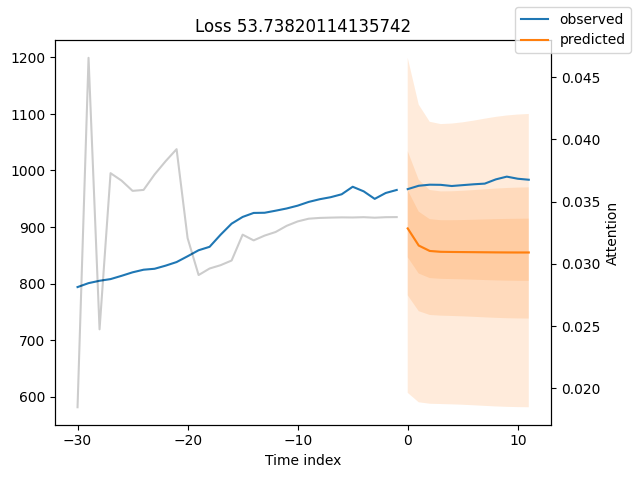

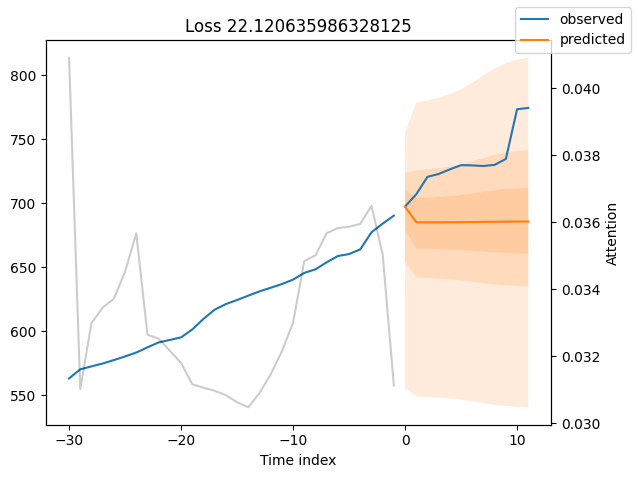

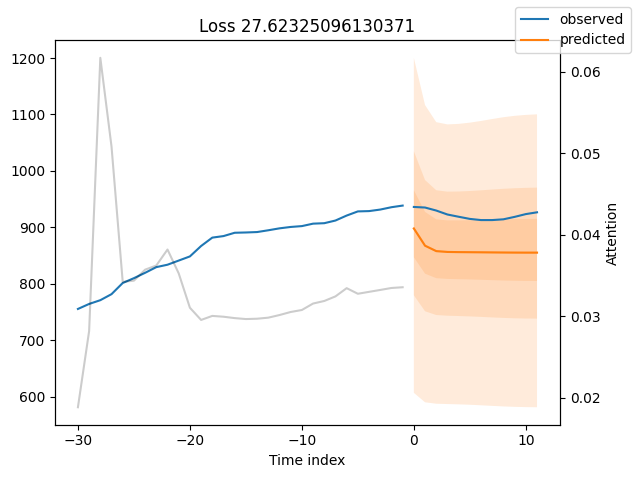

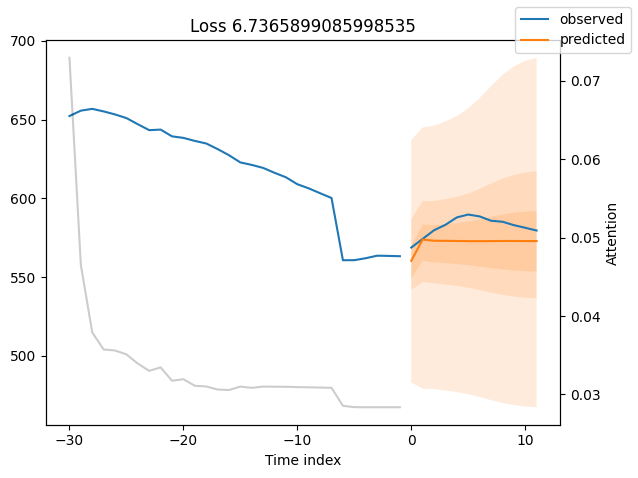

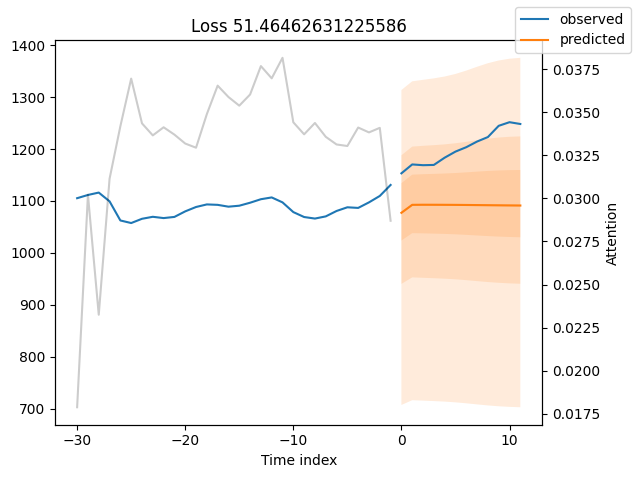

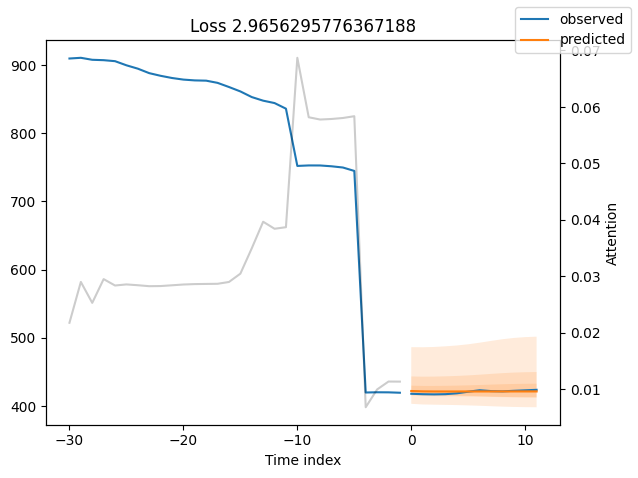

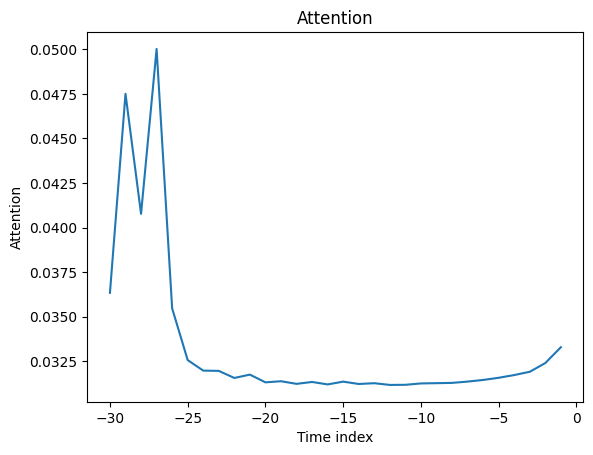

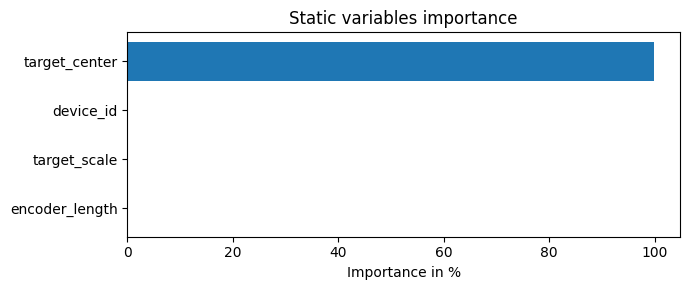

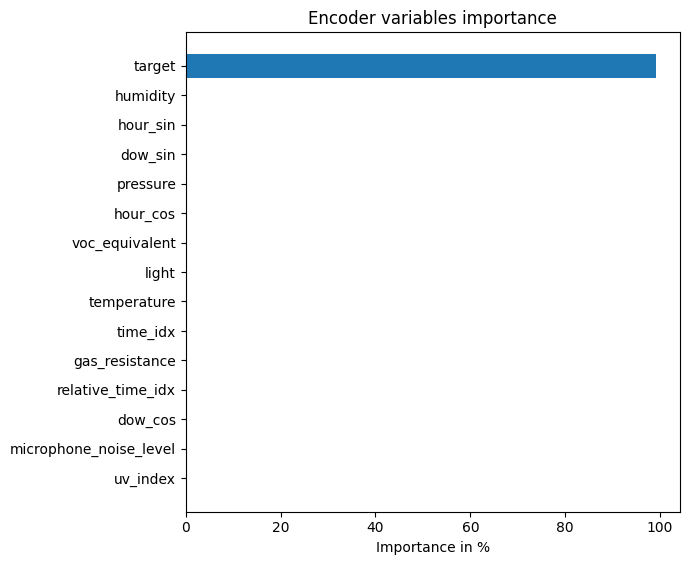

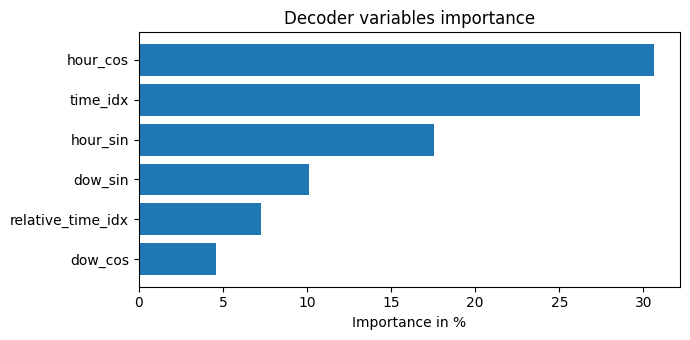

In [21]:
# Plot sample predictions and interpretation
raw_predictions = best_tft.predict(
    val_dataloader, mode="raw", return_x=True
)

# Get the number of predictions
num_predictions = len(raw_predictions.output["prediction"])

# Generate a list of random indices to plot
num_random_plots = min(6, num_predictions)  # Plot up to 6 random predictions
random_indices = np.random.choice(num_predictions, size=num_random_plots, replace=False)


for idx in random_indices:
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.show()

interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
_ = best_tft.plot_interpretation(interpretation)

In [ ]:
# Hyperparameter optimization with Optuna (adjust n_trials/epochs as needed)
import pickle

N_TRIALS = 30
MAX_EPOCHS = 30
MODEL_PATH = "tft_optuna"

study = optimize_hyperparameters(
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    model_path=MODEL_PATH,
    n_trials=N_TRIALS,
    max_epochs=MAX_EPOCHS,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(16, 128),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(1e-3, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=50),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
)

with open("tft_optuna_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

print("Best trial params:\n", study.best_trial.params)

